
# Intraday 5-Minute Backtest


- **`proxy` (default):** Momentum/volatility z-score mapped through a sigmoid → `p_up_5m`.
`proxy`.
> **for pipeline testing**. 

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.api.types import is_datetime64_any_dtype, is_datetime64tz_dtype

## 1) Configuration

In [31]:


# --- Backtest configuration ---
TH_LONG = 0.55              # long threshold on p_up_5m
TH_SHORT = 0.45             # short threshold on p_up_5m
EXEC_DELAY_BARS = 1         # execute 1 bar after signal
HOLD_BARS = 1               # "hold 5 min" == 1 bar in 5-min data
ANNUAL_VOL_TARGET = 0.10    # 10% annualized target volatility
EWMA_LAMBDA = 0.94          # EWMA parameter for vol estimation
FEE_BPS = 0.2               # Costs in basis points per unit turnover
DEFAULT_SPREAD_BPS = 1.0    # fallback spread (bps) if not supplied per bar

# --- Market timing on a 5-minute grid ---
RTH_BARS_PER_DAY_5M = 78              # 6.5 hours * 12 bars/hour for SPY/QQQ RTH
BARS_PER_YEAR = 252 * RTH_BARS_PER_DAY_5M



## 2) Data import

Data → 5-Minute interval

In [32]:

path = "/Users/ken/fins3666_project/Data/SPY_intraday_cleaned.csv"
df = pd.read_csv(path)

# Build/normalize timestamp_ny
if "timestamp_ny" in df.columns:
    s = df["timestamp_ny"]
    if not is_datetime64_any_dtype(s):
        s = pd.to_datetime(s, errors="coerce", utc=False)
else:
    s = None

# If still not datetimelike, derive from timestamp_utc
if s is None or not is_datetime64_any_dtype(s):
    if "timestamp_utc" not in df.columns:
        raise ValueError("Neither a valid 'timestamp_ny' nor 'timestamp_utc' column exists.")
    utc = pd.to_datetime(df["timestamp_utc"], errors="coerce", utc=True)
    s = utc.dt.tz_convert("America/New_York")

# Ensure tz-aware America/New_York
if is_datetime64tz_dtype(s):
    s = s.dt.tz_convert("America/New_York")
else:
    # localize naive values
    try:
        s = s.dt.tz_localize("America/New_York", ambiguous="NaT", nonexistent="shift_forward")
    except TypeError:
        s = s.dt.tz_localize("America/New_York")

df["timestamp_ny"] = s

# Sort and set as index
df = df.sort_values("timestamp_ny").set_index("timestamp_ny")

# Only regular trading hours (Mon–Fri, 09:30–16:00 ET)
df = df[df.index.dayofweek < 5]
df = df.between_time("09:30", "16:00")

# Verify OHLC presence
need_ohlc = ["open", "high", "low", "close"]
missing = [c for c in need_ohlc if c not in df.columns]
if missing:
    raise ValueError(f"Missing OHLC column(s): {missing}")

have_vol = "volume" in df.columns
have_vwap = "vwap" in df.columns

# Resample using 5-minute bins on NY-tz index
agg = {"open": "first", "high": "max", "low": "min", "close": "last"}
if have_vol:
    agg["volume"] = "sum"

if have_vwap and have_vol:
    df["_vwap_x_vol"] = df["vwap"] * df["volume"]
    agg["_vwap_x_vol"] = "sum"

SPY_intraday_5m_df = df.resample("5min", label="left", closed="left").agg(agg)

# Recompute VWAP per bar
if "_vwap_x_vol" in SPY_intraday_5m_df.columns:
    vol = SPY_intraday_5m_df["volume"].replace(0, np.nan)
    SPY_intraday_5m_df["vwap"] = SPY_intraday_5m_df["_vwap_x_vol"] / vol
    SPY_intraday_5m_df = SPY_intraday_5m_df.drop(columns=["_vwap_x_vol"])

# Clean empty bars; returns
SPY_intraday_5m_df = SPY_intraday_5m_df.dropna(subset=["open", "close"])
SPY_intraday_5m_df["ret_5m"] = SPY_intraday_5m_df["close"].pct_change()
SPY_intraday_5m_df["logret_5m"] = np.log(SPY_intraday_5m_df["close"]).diff()

# Ensure the index is explicitly named 'timestamp_ny'
SPY_intraday_5m_df.index.name = "timestamp_ny"

# Save & preview
out_path = "/Users/ken/fins3666_project/Data/SPY_intraday_5m.csv"
SPY_intraday_5m_df.to_csv(out_path, index=True)



/var/folders/vw/jv23dhp563lfbt7xngpfxhkm0000gn/T/ipykernel_80902/2792967154.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s):


In [33]:
# Optional: old path kept for compatibility, but we'll prefer in-memory or a 5-min CSV if present
DATA_PATH = "/Users/ken/fins3666_project/Data/SPY_intraday_cleaned.csv"

def _ensure_5m_schema(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize columns so downstream code works:
    - ensure timestamp_utc exists (derive from index or timestamp_ny if needed)
    - ensure vwap_5m exists (rename vwap -> vwap_5m if that's what you have)
    - ensure symbol exists (default 'SPY')
    """
    df = df.copy()

    # 1) Build timestamp_utc
    if "timestamp_utc" in df.columns:
        df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], errors="coerce", utc=True)
    else:
        # try from index first
        if isinstance(df.index, pd.DatetimeIndex):
            idx = df.index
            if idx.tz is None:
                ts_utc = idx.tz_localize("UTC")
            else:
                ts_utc = idx.tz_convert("UTC")
            df["timestamp_utc"] = ts_utc
        elif "timestamp_ny" in df.columns:
            ts_ny = pd.to_datetime(df["timestamp_ny"], errors="coerce")
            # localize or convert to NY, then to UTC
            if getattr(ts_ny.dt, "tz", None) is None:
                try:
                    ts_ny = ts_ny.dt.tz_localize("America/New_York", ambiguous="NaT", nonexistent="shift_forward")
                except TypeError:
                    ts_ny = ts_ny.dt.tz_localize("America/New_York")
            else:
                ts_ny = ts_ny.dt.tz_convert("America/New_York")
            df["timestamp_utc"] = ts_ny.dt.tz_convert("UTC")
        else:
            raise ValueError("No timestamp found. Provide 'timestamp_utc', an index of datetimes, or 'timestamp_ny'.")

    # 2) vwap_5m: many pipelines call it 'vwap'
    if "vwap_5m" not in df.columns and "vwap" in df.columns:
        df = df.rename(columns={"vwap": "vwap_5m"})

    # 3) symbol default
    if "symbol" not in df.columns:
        df["symbol"] = "SPY"

    # 4) Ensure expected OHLC columns exist
    required = ["open", "high", "low", "close"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing OHLC columns: {missing}")

    return df

# ==== MAIN LOAD LOGIC ====
try:
    # Prefer the in-memory 5-minute DataFrame
    SPY_intraday_5m_df  # name check
    df_5m = _ensure_5m_schema(SPY_intraday_5m_df)
    print("Using in-memory DataFrame: SPY_intraday_5m_df")
except NameError:
    # Try common candidate files (use a 5-min resampled CSV if you have it)
    candidates = [
        "/Users/ken/data/SPY_intraday_5m.csv",
        "/Users/ken/fins3666_project/Data/SPY_intraday_5m.csv",
        DATA_PATH,  # last resort; may not be 5-min bars yet
    ]
    df_5m = None
    for p in candidates:
        if p and Path(p).exists():
            ext = Path(p).suffix.lower()
            if ext == ".parquet":
                tmp = pd.read_parquet(p)
            elif ext == ".csv":
                # Let _ensure_5m_schema parse timestamps
                tmp = pd.read_csv(p)
            else:
                continue
            df_5m = _ensure_5m_schema(tmp)
            print(f"Loaded from: {p}")
            break

    if df_5m is None:
        raise FileNotFoundError(
            "No 5-minute DataFrame found. Define SPY_intraday_5m_df in memory or provide a readable CSV/Parquet."
        )

# Final tidy for downstream code that expects a column and not the index
df_5m = df_5m.sort_values("timestamp_utc").reset_index(drop=True)

# Optional: quick preview
print(df_5m.head())


Using in-memory DataFrame: SPY_intraday_5m_df
      open    high     low   close     volume     vwap_5m    ret_5m  \
0  472.160  472.80  472.05  472.67  3296028.0  473.123145       NaN   
1  472.670  472.74  471.88  471.92  1702267.0  472.350155 -0.001587   
2  471.920  472.10  471.71  471.80  1742326.0  471.853962 -0.000254   
3  471.790  472.09  471.39  471.39  1508728.0  471.711581 -0.000869   
4  471.395  471.95  471.36  471.42  1544082.0  471.630575  0.000064   

   logret_5m             timestamp_utc symbol  
0        NaN 2024-01-02 14:30:00+00:00    SPY  
1  -0.001588 2024-01-02 14:35:00+00:00    SPY  
2  -0.000254 2024-01-02 14:40:00+00:00    SPY  
3  -0.000869 2024-01-02 14:45:00+00:00    SPY  
4   0.000064 2024-01-02 14:50:00+00:00    SPY  


## 3) Soft schema validation

In [34]:

required = ["timestamp_utc","open","high","low","close","volume"]
missing = [c for c in required if c not in df_5m.columns]
if missing:
    raise AssertionError(f"Missing required columns: {missing}")

if not pd.api.types.is_datetime64tz_dtype(df_5m["timestamp_utc"]):
    raise AssertionError("timestamp_utc must be tz-aware UTC datetime64.")

print("Rows:", len(df_5m), "| Columns:", list(df_5m.columns))


Rows: 33292 | Columns: ['open', 'high', 'low', 'close', 'volume', 'vwap_5m', 'ret_5m', 'logret_5m', 'timestamp_utc', 'symbol']


/var/folders/vw/jv23dhp563lfbt7xngpfxhkm0000gn/T/ipykernel_80902/2466916911.py:6: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not pd.api.types.is_datetime64tz_dtype(df_5m["timestamp_utc"]):



## 4) Create temporary probabilities when missing

- `"proxy"`: sigmoid(momentum/vol z-score), **fast**, zero dependencies.

These are **temporary**, need to replace with Malcolm’s calibrated `p_up_5m` when available.


In [35]:

FALLBACK_MODE = "proxy"   
print("Fallback mode:", FALLBACK_MODE)

have_prob = ("p_up_5m" in df_5m.columns) or ("p_up_raw_5m" in df_5m.columns)
print(df_5m)

def _sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

if not have_prob:
    # Basic 5-min returns
    df_5m["ret_5m"] = df_5m["close"].pct_change().fillna(0.0)
    # Proxy: momentum z-score over volatility
    mom = df_5m["close"].pct_change().rolling(3).mean()           # 3-bar momentum
    vol = df_5m["close"].pct_change().rolling(60).std()           # 60-bar vol
    z = (mom / (vol.replace(0, np.nan))).fillna(0.0).clip(-5, 5)  # guard rails
    # Map to probability with temperature k
    k = 1.5
    df_5m["p_up_5m"] = _sigmoid(k * z).clip(0.01, 0.99)
    df_5m["fold_id"] = "FALLBACK_PROXY"
    print("Created p_up_5m via proxy momentum-vol z-score.")
else:
    print("Probability column already present. Skipping fallback.")


Fallback mode: proxy
          open    high     low    close     volume     vwap_5m    ret_5m  \
0      472.160  472.80  472.05  472.670  3296028.0  473.123145       NaN   
1      472.670  472.74  471.88  471.920  1702267.0  472.350155 -0.001587   
2      471.920  472.10  471.71  471.800  1742326.0  471.853962 -0.000254   
3      471.790  472.09  471.39  471.390  1508728.0  471.711581 -0.000869   
4      471.395  471.95  471.36  471.420  1544082.0  471.630575  0.000064   
...        ...     ...     ...      ...        ...         ...       ...   
33287  668.230  668.36  667.61  667.660   921916.0  668.456793 -0.000838   
33288  667.670  668.12  667.39  667.930  1277934.0  667.742963  0.000404   
33289  667.930  668.19  667.54  667.875  1740153.0  667.852084 -0.000082   
33290  667.880  668.15  667.29  667.790  3845787.0  668.162404 -0.000127   
33291  667.810  668.12  667.80  668.000   286426.0  667.946900  0.000314   

       logret_5m             timestamp_utc symbol  
0            N

## 5) Signal → Position (execution delay, 1-bar hold) + Volatility targeting

In [36]:

prob_col = "p_up_5m" if "p_up_5m" in df_5m.columns else ("p_up_raw_5m" if "p_up_raw_5m" in df_5m.columns else None)
if prob_col is None:
    raise ValueError("No probability column available even after fallback.")

df_5m["ret_5m"] = df_5m["close"].pct_change().fillna(0.0)

sig = np.where(df_5m[prob_col] >= TH_LONG, 1, np.where(df_5m[prob_col] <= TH_SHORT, -1, 0)).astype(int)
df_5m["signal"] = sig
df_5m["signal_exec"] = df_5m["signal"].shift(EXEC_DELAY_BARS).fillna(0).astype(int)

def hold_bars(sig_series, k=HOLD_BARS):
    out = np.zeros(len(sig_series), dtype=int)
    i = 0
    s = sig_series.values
    while i < len(s):
        if s[i] != 0:
            out[i:i+k] = s[i]
            i += k
        else:
            i += 1
    return pd.Series(out, index=sig_series.index)

df_5m["raw_position"] = hold_bars(df_5m["signal_exec"], HOLD_BARS)

ret2 = df_5m["ret_5m"].pow(2)
ewvar = ret2.ewm(alpha=(1-EWMA_LAMBDA)).mean()
bar_vol = np.sqrt(ewvar)
ann_vol = bar_vol * np.sqrt(BARS_PER_YEAR)
scale = (ANNUAL_VOL_TARGET / ann_vol).clip(0, 10)
df_5m["position"] = df_5m["raw_position"] * scale.fillna(0.0)

df_5m[["timestamp_utc","signal","signal_exec","raw_position","position"]]


,timestamp_utc,signal,signal_exec,raw_position,position
0,2024-01-02 14:30:00+00:00,0,0,0,0.000000
1,2024-01-02 14:35:00+00:00,0,0,0,0.000000
2,2024-01-02 14:40:00+00:00,0,0,0,0.000000
3,2024-01-02 14:45:00+00:00,0,0,0,0.000000
4,2024-01-02 14:50:00+00:00,0,0,0,0.000000
...,...,...,...,...,...
33287,2025-10-22 19:40:00+00:00,0,1,1,0.808373
33288,2025-10-22 19:45:00+00:00,1,0,0,0.000000
33289,2025-10-22 19:50:00+00:00,-1,1,1,0.854014
33290,2025-10-22 19:55:00+00:00,0,-1,-1,-0.880196


## 6) Costs and PnL

In [37]:

turnover = df_5m["position"].diff().abs().fillna(0.0)
spread_bps = df_5m.get("spread_bps_est", pd.Series(DEFAULT_SPREAD_BPS, index=df_5m.index))
cost_per_turnover = (FEE_BPS + 0.5 * spread_bps) / 1e4

gross = df_5m["position"].shift(1).fillna(0.0) * df_5m["ret_5m"]
df_5m["pnl_net"] = gross - turnover * cost_per_turnover
df_5m["equity"]  = (1.0 + df_5m["pnl_net"]).cumprod()

df_5m[["timestamp_utc","ret_5m","position","pnl_net","equity"]].tail()


,timestamp_utc,ret_5m,position,pnl_net,equity
33287,2025-10-22 19:40:00+00:00,-0.000838,0.808373,-0.000676,0.319904
33288,2025-10-22 19:45:00+00:00,0.000404,0.000000,0.000270,0.319991
33289,2025-10-22 19:50:00+00:00,-0.000082,0.854014,-0.000060,0.319971
33290,2025-10-22 19:55:00+00:00,-0.000127,-0.880196,-0.000230,0.319898
33291,2025-10-22 20:00:00+00:00,0.000314,0.000000,-0.000338,0.319789


## 7) Metrics

In [38]:

def sharpe(x, ann_bars=BARS_PER_YEAR):
    mu = x.mean() * ann_bars
    sd = x.std(ddof=1) * np.sqrt(ann_bars)
    return float("nan") if sd == 0 else float(mu / sd)

def sortino(x, ann_bars=BARS_PER_YEAR):
    mu = x.mean() * ann_bars
    dn = x[x < 0].std(ddof=1) * np.sqrt(ann_bars)
    return float("nan") if dn == 0 else float(mu / dn)

def max_drawdown(equity):
    peak = equity.cummax()
    dd = equity/peak - 1.0
    return float(dd.min())

metrics = {
    "Sharpe":  sharpe(df_5m["pnl_net"]),
    "Sortino": sortino(df_5m["pnl_net"]),
    "MaxDD":   max_drawdown(df_5m["equity"]),
    "HitRate": float((df_5m["pnl_net"] > 0).mean()),
    "Turnover(abs Δpos)": float(df_5m["position"].diff().abs().fillna(0.0).sum()),
}
metrics


{'Sharpe': -5.3122575202849145,
 'Sortino': -6.1493577273420295,
 'MaxDD': -0.683299701723481,
 'HitRate': 0.33251231527093594,
 'Turnover(abs Δpos)': 19668.389293640863}

## 8) Trades ledger (1-bar trades for HOLD_BARS=1)

In [39]:

trades = []
pos = df_5m["raw_position"].values
for i in range(len(pos)):
    if pos[i] != 0 and (i == 0 or pos[i-1] == 0):
        j = min(i + HOLD_BARS, len(pos)-1)
        side = "LONG" if pos[i] > 0 else "SHORT"
        px_in  = df_5m["close"].iat[i-1] if i > 0 else df_5m["open"].iat[i]
        px_out = df_5m["close"].iat[j]
        pnl = (px_out/px_in - 1) * (1 if side == "LONG" else -1)
        trades.append({
            "t_entry": df_5m["timestamp_utc"].iat[i],
            "t_exit":  df_5m["timestamp_utc"].iat[j],
            "side": side,
            "px_in": float(px_in), "px_out": float(px_out),
            "pnl_gross": float(pnl),
        })
trades_ledger = pd.DataFrame(trades)
trades_ledger.head()


,t_entry,t_exit,side,px_in,px_out,pnl_gross
0,2024-01-02 19:40:00+00:00,2024-01-02 19:45:00+00:00,SHORT,471.53,471.3740,0.000331
1,2024-01-02 20:40:00+00:00,2024-01-02 20:45:00+00:00,SHORT,470.76,471.2300,-0.000998
2,2024-01-03 15:00:00+00:00,2024-01-03 15:05:00+00:00,SHORT,469.97,470.0899,-0.000255
3,2024-01-03 15:15:00+00:00,2024-01-03 15:20:00+00:00,SHORT,469.40,469.4500,-0.000107
4,2024-01-03 15:40:00+00:00,2024-01-03 15:45:00+00:00,SHORT,468.86,468.8200,0.000085


## 9) Regime / Event slicing (optional)

In [40]:

slices = {}

if "regime" in df_5m.columns:
    s = df_5m.groupby("regime")["pnl_net"].apply(lambda x: {
        "Sharpe": sharpe(x), "Sortino": sortino(x), "AvgPnL(5m)": float(x.mean())
    })
    slices["by_regime"] = s.to_dict()

if "event_flag" in df_5m.columns:
    s2 = df_5m.groupby("event_flag")["pnl_net"].apply(lambda x: {
        "Sharpe": sharpe(x), "Sortino": sortino(x), "AvgPnL(5m)": float(x.mean())
    })
    slices["by_event_flag"] = s2.to_dict()

slices if slices else "No regime/event columns found."


'No regime/event columns found.'

## 10) Threshold sweep (justify 0.55/0.45) → to be deleted

In [41]:

def hold_bars_for_sweep(sig_series, k):
    out = np.zeros(len(sig_series), dtype=int)
    i = 0
    s = sig_series.values if hasattr(sig_series, "values") else sig_series
    while i < len(s):
        if s[i] != 0:
            out[i:i+k] = s[i]
            i += k
        else:
            i += 1
    return out

def threshold_sweep(df, lo=0.50, hi=0.60, step=0.01):
    rows = []
    probs = df["p_up_5m"] if "p_up_5m" in df.columns else df["p_up_raw_5m"]
    for th in np.round(np.arange(lo, hi+1e-9, step), 2):
        sig = np.where(probs >= th, 1, np.where(probs <= 1-th, -1, 0)).astype(int)
        sig_exec = pd.Series(sig, index=df.index).shift(EXEC_DELAY_BARS).fillna(0).astype(int)
        raw_position = hold_bars_for_sweep(sig_exec, HOLD_BARS)

        ret2 = df["ret_5m"].pow(2)
        ewvar = ret2.ewm(alpha=(1-EWMA_LAMBDA)).mean()
        bar_vol = np.sqrt(ewvar)
        ann_vol = bar_vol * np.sqrt(BARS_PER_YEAR)
        scale = (ANNUAL_VOL_TARGET / ann_vol).clip(0, 10)
        position = raw_position * scale.fillna(0.0)

        turnover = pd.Series(position).diff().abs().fillna(0.0)
        spread_bps = df.get("spread_bps_est", pd.Series(DEFAULT_SPREAD_BPS, index=df.index))
        cost_per_turnover = (FEE_BPS + 0.5 * spread_bps) / 1e4
        gross = pd.Series(position).shift(1).fillna(0.0) * df["ret_5m"]
        pnl_net = gross - turnover * cost_per_turnover

        def sharpe_local(x):
            mu = x.mean() * BARS_PER_YEAR
            sd = x.std(ddof=1) * (BARS_PER_YEAR ** 0.5)
            return float("nan") if sd == 0 else float(mu / sd)

        def sortino_local(x):
            mu = x.mean() * BARS_PER_YEAR
            dn = x[x < 0].std(ddof=1) * (BARS_PER_YEAR ** 0.5)
            return float("nan") if dn == 0 else float(mu / dn)

        row = {
            "th_long": float(th),
            "th_short": float(1-th),
            "Sharpe": sharpe_local(pnl_net),
            "Sortino": sortino_local(pnl_net),
            "MaxDD": float(((1+pnl_net).cumprod()/ (1+pnl_net).cumprod().cummax() - 1).min()),
            "Turnover": float(turnover.sum()),
        }
        rows.append(row)
    return pd.DataFrame(rows)

if "ret_5m" not in df_5m.columns:
    df_5m["ret_5m"] = df_5m["close"].pct_change().fillna(0.0)

sweep_df = threshold_sweep(df_5m)
sweep_df


,th_long,th_short,Sharpe,Sortino,MaxDD,Turnover
0,0.50,0.50,-3.830370,-3.900671,-0.763632,21408.421815
1,0.51,0.49,-5.074312,-6.184214,-0.698011,21100.836921
2,0.52,0.48,-4.987972,-6.037905,-0.683896,20842.263352
3,0.53,0.47,-5.153861,-6.182646,-0.692178,20554.286247
4,0.54,0.46,-5.072936,-6.016508,-0.677442,20160.454775
5,0.55,0.45,-5.312258,-6.149358,-0.683300,19668.389294
6,0.56,0.44,-4.954359,-5.661936,-0.652095,18997.458837
7,0.57,0.43,-4.859491,-5.457870,-0.639570,18360.637295
8,0.58,0.42,-4.680375,-5.141623,-0.621562,17471.023751
9,0.59,0.41,-4.595841,-4.888600,-0.608118,16756.082259


## 11) Plot equity curve

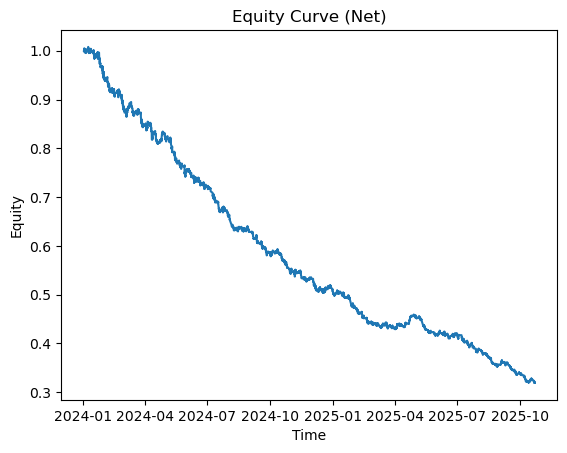

In [42]:
plt.figure()
plt.plot(df_5m["timestamp_utc"], df_5m["equity"])
plt.title("Equity Curve (Net)")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.show()


# 12) Performance Metrics

In [43]:
ann = BARS_PER_YEAR
bar_rets = df_5m["pnl_net"].astype(float)

# --- Returns & risk ---
total_return = float(df_5m["equity"].iloc[-1] - 1.0)
years = len(df_5m) / ann
cagr = float(df_5m["equity"].iloc[-1]**(1/years) - 1.0) if years > 0 else np.nan
ann_return = float(bar_rets.mean() * ann)
ann_vol = float(bar_rets.std(ddof=1) * np.sqrt(ann))
sharpe = float(ann_return / ann_vol) if ann_vol > 0 else np.nan

# --- Trades & win rate (HOLD_BARS (K) =1) ---
trades = []
pos = df_5m["raw_position"].fillna(0).astype(int).values
for i in range(len(pos)):
    if pos[i] != 0 and (i == 0 or pos[i-1] == 0):
        j = min(i + HOLD_BARS - 1, len(pos) - 1)  # inclusive end index for K-bar hold
        # Conservative fill: in at prev close (if exists), out at exit close
        px_in  = df_5m["close"].iat[i-1] if i > 0 else df_5m["open"].iat[i]
        px_out = df_5m["close"].iat[j]
        side = 1 if pos[i] > 0 else -1
        gross = side * (px_out/px_in - 1.0)
        trades.append({"i_entry": i, "i_exit": j, "side": side, "pnl_gross": float(gross)})

trades_ledger = pd.DataFrame(trades)
n_trades = int(len(trades_ledger))
win_rate = float((trades_ledger["pnl_gross"] > 0).mean()) if n_trades else np.nan

# --- Benchmark, alpha, beta, correlation (use underlying 5m return as benchmark) ---
bench = df_5m["ret_5m"].astype(float)
cov = np.cov(bar_rets, bench)[0, 1]
var_b = np.var(bench)
beta = float(cov / var_b) if var_b > 0 else np.nan
alpha_bar = float(bar_rets.mean() - beta * bench.mean()) if np.isfinite(beta) else np.nan
alpha_ann = float(alpha_bar * ann) if np.isfinite(alpha_bar) else np.nan
corr = float(np.corrcoef(bar_rets, bench)[0, 1]) if bench.std(ddof=1) > 0 else np.nan

# --- Pack results ---
perf = pd.Series({
    "Total Return": total_return,
    "CAGR": cagr,
    "Ann.Return": ann_return,
    "Ann.Vol": ann_vol,
    "Sharpe": sharpe,
    "Trades": n_trades,
    "Win Rate": win_rate,
    "Alpha (ann.)": alpha_ann,
    "Beta": beta,
    "Corr w/ Benchmark": corr,
})
display(perf.to_frame("Value"))



,Value
Total Return,-0.680211
CAGR,-0.489888
Ann.Return,-0.665269
Ann.Vol,0.125233
Sharpe,-5.312258
Trades,5036.000000
Win Rate,0.479944
Alpha (ann.),-0.680514
Beta,0.070079
Corr w/ Benchmark,0.091305
